In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path

# pytorch related stuff
import torch  # for dealing with tensors, and other animals
import torch.nn as nn # for NN stuff
import torch.nn.functional as F # 
import torch.distributions as D # for distributions

# SBI related stuff
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, SNPE_A, SNPE_B, SNLE, SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn

In [2]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v1.25.0
Running on torch: v2.0.1+cpu
Running on sbi: v0.21.0


# SLCP (SNLE-B [papamakarios et al.])

In [28]:
seed = 247
torch.manual_seed(seed)
# hyperparams
dim = 5
n = 10000
lower = -3
upper = 3

In [29]:
# define prior
prior = utils.BoxUniform(low=lower*torch.ones(dim), high=upper*torch.ones(dim)) #, device="cuda") # 

In [30]:
prior.sample((3,))

tensor([[ 1.4530, -2.0454, -1.0162,  1.8915,  1.5089],
        [-1.0517,  2.9575, -2.1390, -0.9307, -1.1156],
        [ 2.2792, -0.5313, -1.8100, -2.1566, -1.3885]])

In [31]:
theta_true = torch.tensor([[0.7,-2.9,-1,-.9,0.6]])

In [32]:
# define the simulator (creates a shifted crescent shape)
def simulator(theta, nx=4):
    n = theta.shape[0] 
    mvn = torch.zeros(n, nx*2)
    for i in range(n):
      mu = theta[i,:2]
      s1 = theta[i,2]**2
      s2 = theta[i,3]**2
      r = torch.tanh(theta[i,4])
      S = torch.tensor([[s1**2, r*s1*s2],[r*s1*s2, s2**2]])
      mvn[i,:] = D.MultivariateNormal(loc=mu, covariance_matrix=S).sample((nx,)).flatten()
    return mvn

In [33]:
simulator(theta_true)

tensor([[-0.2956, -3.8656,  0.5201, -1.7673, -0.8309, -3.4218, -0.6529, -3.3707]])

In [36]:
x_obs = simulator(theta_true, 8)

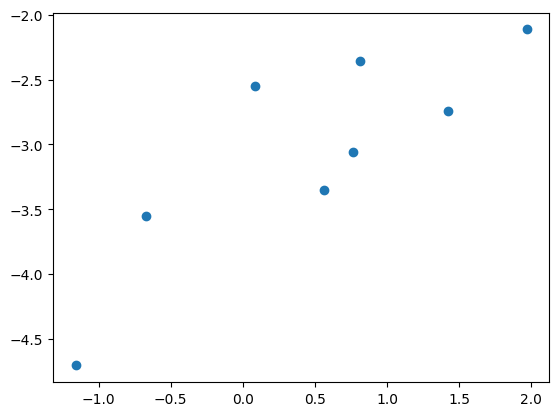

In [37]:
x_obs_ = x_obs.reshape(8,2)
plt.scatter(x_obs_[:,0], x_obs_[:,1])

In [38]:
torch.save(x_obs, "SLCP_8points_x_obs.pt")

In [39]:
x_obs = torch.load("SLCP_8points_x_obs.pt")

## Generate true posterior (an attempt)

In [40]:
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS

pyro.set_rng_seed(0)

In [41]:
def model(obs):
    assert obs.shape == (8, 2)
    with pyro.plate("thetas", 5):
        theta = pyro.sample("theta", dist.Uniform(lower, upper))
    mu = theta[:2]
    s1 = theta[2]**2
    s2 = theta[3]**2
    r = theta[4].tanh()
    s12 = r*s1*s2
    S = torch.stack([torch.stack([s1**2, s12]),
                     torch.stack([s12, s2**2])])
    with pyro.plate("data", 8):
        return pyro.sample("obs", dist.MultivariateNormal(mu, S), obs=obs)

In [48]:
nuts_kernel = NUTS(model)
mcmc = MCMC(
    nuts_kernel,
    num_samples=10000,
    warmup_steps=1000,
    num_chains=10,
)

C:\Users\davidrefaeli\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyro\infer\mcmc\api.py:497: UserWarning: num_chains=10 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(


In [49]:
mcmc.run(x_obs.reshape(8,2))

Sample [9]: 100%|█████████████████████████████████| 11000/11000 [04:15, 43.01it/s, step size=2.84e-01, acc. prob=0.884]


In [50]:
sample = mcmc.get_samples()["theta"]
torch.save(sample, "SLCP_sample_8points_mcmc.pt")

In [51]:
sample = torch.load("SLCP_sample_8points_mcmc.pt")

In [52]:
sample.shape

torch.Size([100000, 5])

In [53]:
p = torch.full((1,100000), fill_value=1/100000)
idx = p.multinomial(num_samples=10000, replacement=False)
ids = idx.squeeze()
true_sample_red = sample[ids,:]
true_sample = true_sample_red

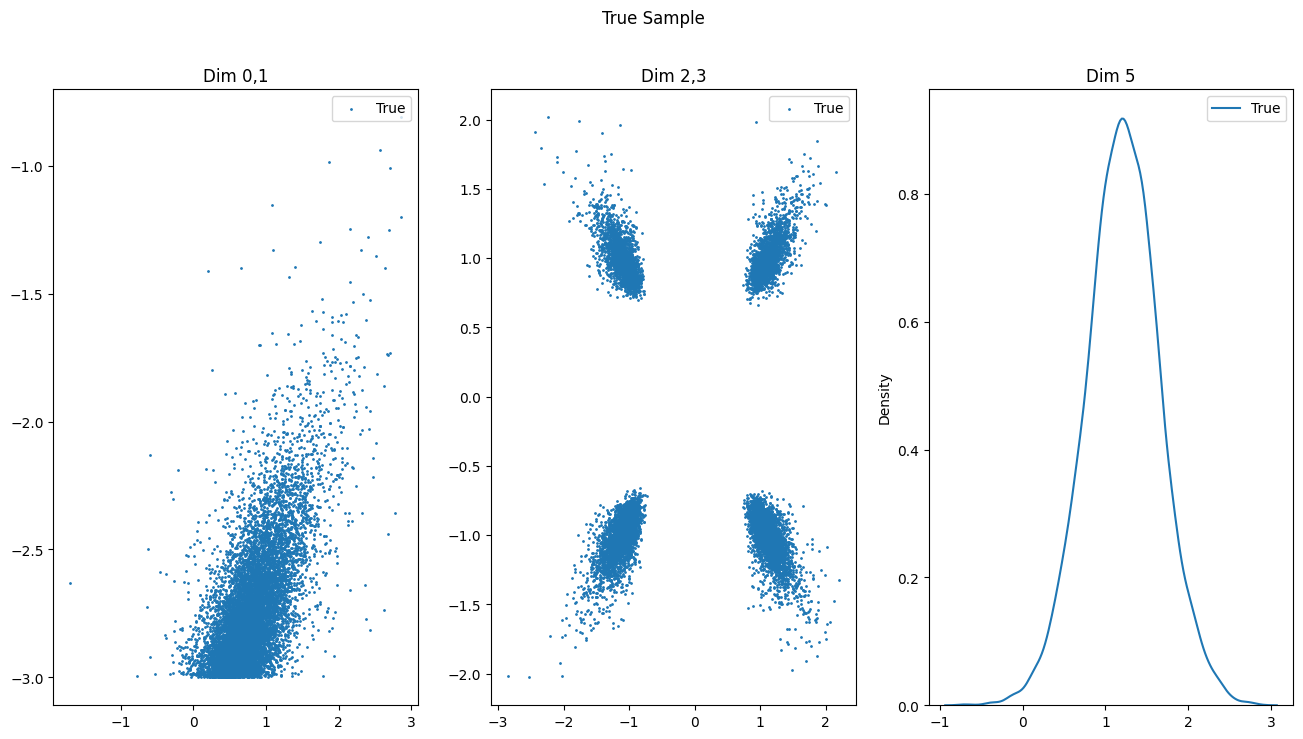

In [54]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
fig.suptitle(f'True Sample')
a1=axs[0].scatter(true_sample[:,0].numpy(),true_sample[:,1].numpy(), s=1, label=f"True")
axs[0].legend(loc="upper right")
axs[0].title.set_text('Dim 0,1')
b1=axs[1].scatter(true_sample[:,2].numpy(),true_sample[:,3].numpy(), s=1, label=f"True")
axs[1].legend(loc="upper right")
axs[1].title.set_text('Dim 2,3')
c1 = sns.kdeplot(true_sample[:,4].numpy(), ax=axs[2], label=f"True")
axs[2].legend(loc="upper right")
axs[2].title.set_text('Dim 5')